# Deep Learning HW2 - Problem 3
### Ehsan Sharifian 400201529

---

## Part a

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import matplotlib.pyplot as plt
import math
from matplotlib import rc
from google.colab import drive

In [2]:
drive.mount('/content/drive', force_remount=True)
dir = "/content/drive/MyDrive/Deep Learning/HW02/Question3/"

Mounted at /content/drive


In [3]:
train_df = pd.read_csv(dir + 'Q3_train.csv')
test_df = pd.read_csv(dir + 'Q3_test.csv')
train_df.head(2)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149


In [4]:
# Creating a Custom Dataset
from torch.utils.data import Dataset
from math import sqrt
import string

device = "cuda" if torch.cuda.is_available() else "cpu"

def Vector_to_Picture(vector):
  picture_dim = int(sqrt(len(vector)))
  return torch.reshape(vector, (picture_dim, -1))

class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=Vector_to_Picture, target_transform=None):
        self.data = dataframe.iloc[:,1:]
        self.targets = dataframe["label"]
        self.transform = transform
        self.target_transform = target_transform
        self.classes = list(string.ascii_uppercase)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        data = torch.tensor(self.data.iloc[idx]).to(device).float()
        target = torch.tensor(self.targets.iloc[idx]).to(device)
        if self.transform:
            data = self.transform(data)
        if self.target_transform:
            target = self.target_transform(target)
        return data, target

train_data = CustomDataset(train_df)
test_data = CustomDataset(test_df)

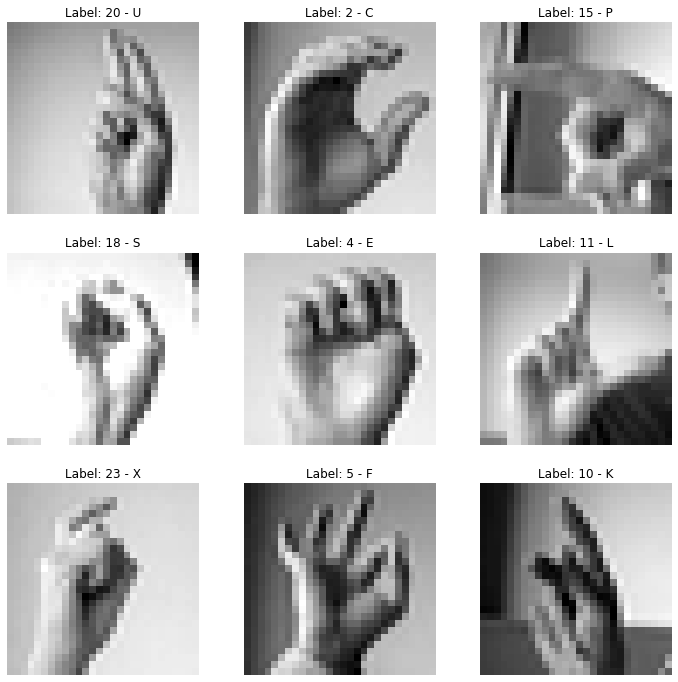

In [5]:
plt.figure(figsize=(12, 12))
for i in range(9):
  index = torch.randint(len(train_data), (1,))[0]
  img, label = train_data[index.item()]
  plt.subplot(3, 3, i+1)
  plt.imshow(img.squeeze(), cmap="gray")
  label = train_data.targets[index.item()]
  Class = train_data.classes[label.item()]
  plt.title(f"Label: {label} - {Class}")
  plt.axis(False)
plt.show()

## Part b

In [6]:
import torch.nn as nn
class NeuralNetwork(nn.Module):
    def __init__(self, Dropout=False):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        if Dropout:
          self.linear_relu_stack = nn.Sequential(
              nn.Linear(784, 500),
              nn.ReLU(),
              nn.Linear(500, 280),
              nn.Dropout(p=0.4),
              nn.ReLU(),
              nn.Linear(280, 180),
              nn.Dropout(p=0.4),
              nn.ReLU(),
              nn.Linear(180, 90),
              nn.Dropout(p=0.2),
              nn.ReLU(),
              nn.Linear(90, 50),
              nn.Dropout(p=0.2),
              nn.ReLU(),
              nn.Linear(50, 25),
          )
        else:
          self.linear_relu_stack = nn.Sequential(
              nn.Linear(784, 500),
              nn.ReLU(),
              nn.Linear(500, 280),
              nn.ReLU(),
              nn.Linear(280, 180),
              nn.ReLU(),
              nn.Linear(180, 90),
              nn.ReLU(),
              nn.Linear(90, 50),
              nn.ReLU(),
              nn.Linear(50, 25),
          )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [7]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"

class model_builder():
    def __init__(self, training_data, validation_data, test_data, batch_size, Dropout, learning_rate, loss_fn, optimizer):
      self.train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
      self.validation_dataloader = DataLoader(validation_data, batch_size=batch_size, shuffle=True)
      self.test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

      self.model = NeuralNetwork(Dropout=Dropout).to(device)
      self.model.train()

      if (optimizer == 'SGD'):
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=learning_rate)
      elif (optimizer == 'ADAM'):
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)

      self.loss_fn = loss_fn

class nn_optimizer():
    def __init__(self, model_builder, epochs):
      self.model_builder = model_builder
      self.epochs = epochs
      self.train_loss = []
      self.train_accuracy = []
      self.validation_loss = []
      self.validation_accuracy = []

    def train_loop(self):
      self.model_builder.model.train()
      size = len(self.model_builder.train_dataloader.dataset)
      for batch, (X, y) in enumerate(self.model_builder.train_dataloader):
          # Compute prediction and loss
          pred = self.model_builder.model(X)
          loss = self.model_builder.loss_fn(pred, y)

          # Backpropagation
          self.model_builder.optimizer.zero_grad()
          loss.backward()
          self.model_builder.optimizer.step()

          if batch % 100 == 0:
              loss, current = loss.item(), batch * len(X)
              print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


    def test_loop(self, name):
        if (name == 'train'):
          dataloader = self.model_builder.train_dataloader
        elif (name == 'test'):
          dataloader = self.model_builder.test_dataloader
        elif (name == 'validation'):
          dataloader = self.model_builder.validation_dataloader
        self.model_builder.model.eval()
        size = len(dataloader.dataset)
        num_batches = len(dataloader)
        test_loss, correct = 0, 0

        with torch.no_grad():
            for X, y in dataloader:
                pred = self.model_builder.model(X)
                test_loss += self.model_builder.loss_fn(pred, y).item()
                correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        test_loss /= num_batches
        correct /= size
        print(f"{name} Accuracy: {(100*correct):>0.1f}%, {name} Avg loss: {test_loss:>8f}")
        return correct,test_loss

    def fit(self, name):
        max_accuracy = 0
        for t in range(self.epochs):
          print(f"Epoch {t+1}\n-------------------------------------")
          self.train_loop()
          correct ,loss = self.test_loop('train')
          self.train_accuracy.append(correct)
          self.train_loss.append(loss)
          correct, loss = self.test_loop('validation')
          self.validation_accuracy.append(correct)
          self.validation_loss.append(loss)
          print('\n')
          # saving best model
          if (correct > max_accuracy):
            torch.save(self.model_builder.model, name + '.pth')
            max_accuracy = correct
        print("Done!")

frac = 0.8
training_data, validation_data = random_split(train_data, [int(frac*len(train_data)), len(train_data)-int(frac*len(train_data))])

In [8]:
batch_size = 32
learning_rate = 1e-3
epochs = 20
loss_fn = nn.CrossEntropyLoss()

model_builder_NoDropout_SGD = model_builder(training_data, validation_data, test_data, batch_size, False, learning_rate, loss_fn, 'SGD')
optimizer_NoDropout_SGD = nn_optimizer(model_builder_NoDropout_SGD,epochs)
optimizer_NoDropout_SGD.fit(dir + 'model_NoDropout_SGD')

Epoch 1
-------------------------------------
loss: 4.182151  [    0/21964]
loss: 3.015842  [ 3200/21964]
loss: 2.967578  [ 6400/21964]
loss: 2.838157  [ 9600/21964]
loss: 2.821852  [12800/21964]
loss: 2.509725  [16000/21964]
loss: 2.504010  [19200/21964]
train Accuracy: 24.3%, train Avg loss: 2.397864
validation Accuracy: 23.5%, validation Avg loss: 2.404669


Epoch 2
-------------------------------------
loss: 2.647892  [    0/21964]
loss: 2.076390  [ 3200/21964]
loss: 1.821785  [ 6400/21964]
loss: 1.635245  [ 9600/21964]
loss: 1.997198  [12800/21964]
loss: 1.341180  [16000/21964]
loss: 1.617492  [19200/21964]
train Accuracy: 41.9%, train Avg loss: 1.717693
validation Accuracy: 42.9%, validation Avg loss: 1.713140


Epoch 3
-------------------------------------
loss: 1.881319  [    0/21964]
loss: 1.302419  [ 3200/21964]
loss: 1.700875  [ 6400/21964]
loss: 1.262000  [ 9600/21964]
loss: 1.118894  [12800/21964]
loss: 1.173126  [16000/21964]
loss: 1.059209  [19200/21964]
train Accuracy: 

In [9]:
batch_size = 32
learning_rate = 1e-3
epochs = 20
loss_fn = nn.CrossEntropyLoss()

model_builder_NoDropout_ADAM = model_builder(training_data, validation_data, test_data, batch_size, False, learning_rate, loss_fn, 'ADAM')
optimizer_NoDropout_ADAM = nn_optimizer(model_builder_NoDropout_ADAM,epochs)
optimizer_NoDropout_ADAM.fit(dir + 'model_NoDropout_ADAM')

Epoch 1
-------------------------------------
loss: 3.696025  [    0/21964]
loss: 3.213026  [ 3200/21964]
loss: 2.901999  [ 6400/21964]
loss: 2.777374  [ 9600/21964]
loss: 2.088390  [12800/21964]
loss: 2.064613  [16000/21964]
loss: 1.943118  [19200/21964]
train Accuracy: 37.4%, train Avg loss: 1.783910
validation Accuracy: 37.0%, validation Avg loss: 1.788926


Epoch 2
-------------------------------------
loss: 1.809782  [    0/21964]
loss: 2.077886  [ 3200/21964]
loss: 1.828251  [ 6400/21964]
loss: 1.674330  [ 9600/21964]
loss: 1.385639  [12800/21964]
loss: 1.465906  [16000/21964]
loss: 1.058877  [19200/21964]
train Accuracy: 37.7%, train Avg loss: 1.871720
validation Accuracy: 37.6%, validation Avg loss: 1.867340


Epoch 3
-------------------------------------
loss: 1.841313  [    0/21964]
loss: 1.420588  [ 3200/21964]
loss: 1.293791  [ 6400/21964]
loss: 1.108623  [ 9600/21964]
loss: 0.917705  [12800/21964]
loss: 1.368326  [16000/21964]
loss: 0.951546  [19200/21964]
train Accuracy: 

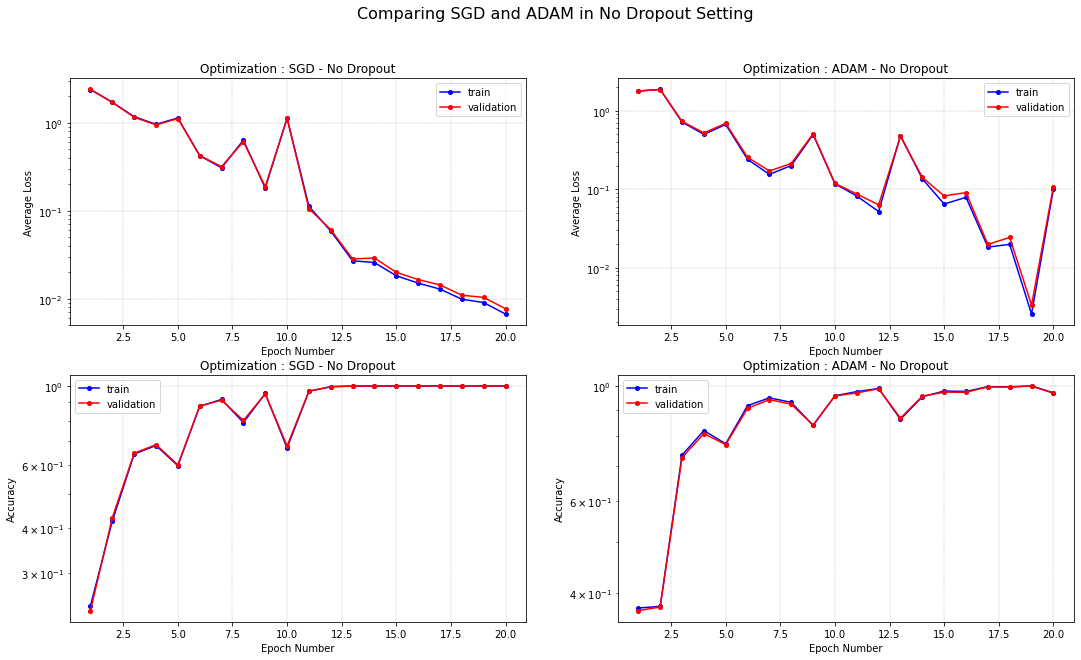

In [10]:
# Plotting the loss and accuracy curves
plt.figure(figsize=(18, 10))

plt.subplot(2, 2, 1)
plt.plot(range(1,21), optimizer_NoDropout_SGD.train_loss, label = 'train', color = 'b', marker = 'o', ms = 4)
plt.plot(range(1,21), optimizer_NoDropout_SGD.validation_loss, label = 'validation', color = 'r',  marker = 'o', ms = 4)
plt.xlabel('Epoch Number')
plt.ylabel('Average Loss')
plt.title('Optimization : SGD - No Dropout')
plt.grid(linestyle = '--', linewidth = 0.4)
plt.yscale('log')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(range(1,21), optimizer_NoDropout_ADAM.train_loss, label = 'train', color = 'b', marker = 'o', ms = 4)
plt.plot(range(1,21), optimizer_NoDropout_ADAM.validation_loss, label = 'validation', color = 'r',  marker = 'o', ms = 4)
plt.xlabel('Epoch Number')
plt.ylabel('Average Loss')
plt.title('Optimization : ADAM - No Dropout')
plt.grid(linestyle = '--', linewidth = 0.4)
plt.yscale('log')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(range(1,21), optimizer_NoDropout_SGD.train_accuracy, label = 'train', color = 'b', marker = 'o', ms = 4)
plt.plot(range(1,21), optimizer_NoDropout_SGD.validation_accuracy, label = 'validation', color = 'r',  marker = 'o', ms = 4)
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.title('Optimization : SGD - No Dropout')
plt.grid(linestyle = '--', linewidth = 0.4)
plt.yscale('log')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(range(1,21), optimizer_NoDropout_ADAM.train_accuracy, label = 'train', color = 'b', marker = 'o', ms = 4)
plt.plot(range(1,21), optimizer_NoDropout_ADAM.validation_accuracy, label = 'validation', color = 'r',  marker = 'o', ms = 4)
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.title('Optimization : ADAM - No Dropout')
plt.grid(linestyle = '--', linewidth = 0.4)
plt.yscale('log')
plt.legend()

plt.suptitle("Comparing SGD and ADAM in No Dropout Setting", size = 16)
plt.show()

<div dir="rtl"> <font size="4" face="vazirmatn">    
در الگوریتم SGD
گرادیان برای همه‌ی پارامترها محاسبه شده و نرخ یادگیری برای همه‌ی پارامتر‌ها یکسان است و عملکرد آن هنگامی که نرخ یادگیری پایین باشد مشابه همان گرادیان کاهشی است. اما در روش
ADAM
گرادیان‌ها به صورت منحصربه‌فرد و وفقی (adaptive) برای هر پارامتر محاسبه می‌شوند که در این محاسبه از تخمین moment‌های مرتبه اول و مرتبه دوم گرادیان در آن استفاده می‌شود.

در این تسک روش SGD به نتایج بهتری ختم شده است.
</font> </div> 

## Part c

In [11]:
batch_size = 32
learning_rate = 1e-3
epochs = 20
loss_fn = nn.CrossEntropyLoss()

model_builder_WithDropout_SGD = model_builder(training_data, validation_data, test_data, batch_size, True, learning_rate, loss_fn, 'SGD')
optimizer_WithDropout_SGD = nn_optimizer(model_builder_WithDropout_SGD,epochs)
optimizer_WithDropout_SGD.fit(dir + 'model_WithDropout_SGD')

Epoch 1
-------------------------------------
loss: 5.398744  [    0/21964]
loss: 3.325549  [ 3200/21964]
loss: 3.247998  [ 6400/21964]
loss: 3.217753  [ 9600/21964]
loss: 3.150099  [12800/21964]
loss: 3.214173  [16000/21964]
loss: 3.205783  [19200/21964]
train Accuracy: 12.2%, train Avg loss: 3.113061
validation Accuracy: 11.7%, validation Avg loss: 3.115742


Epoch 2
-------------------------------------
loss: 3.181371  [    0/21964]
loss: 3.148019  [ 3200/21964]
loss: 3.172114  [ 6400/21964]
loss: 3.145025  [ 9600/21964]
loss: 2.924337  [12800/21964]
loss: 2.931242  [16000/21964]
loss: 2.919096  [19200/21964]
train Accuracy: 15.7%, train Avg loss: 2.840483
validation Accuracy: 15.8%, validation Avg loss: 2.844988


Epoch 3
-------------------------------------
loss: 2.927242  [    0/21964]
loss: 2.884507  [ 3200/21964]
loss: 2.931730  [ 6400/21964]
loss: 2.940064  [ 9600/21964]
loss: 2.936965  [12800/21964]
loss: 2.744676  [16000/21964]
loss: 2.689152  [19200/21964]
train Accuracy: 

In [12]:
batch_size = 32
learning_rate = 1e-3
epochs = 20
loss_fn = nn.CrossEntropyLoss()

model_builder_WithDropout_ADAM = model_builder(training_data, validation_data, test_data, batch_size, True, learning_rate, loss_fn, 'ADAM')
optimizer_WithDropout_ADAM = nn_optimizer(model_builder_WithDropout_ADAM,epochs)
optimizer_WithDropout_ADAM.fit(dir + 'model_WithDropout_ADAM')

Epoch 1
-------------------------------------
loss: 5.497351  [    0/21964]
loss: 3.237827  [ 3200/21964]
loss: 3.218013  [ 6400/21964]
loss: 3.177031  [ 9600/21964]
loss: 3.362759  [12800/21964]
loss: 2.869569  [16000/21964]
loss: 2.814873  [19200/21964]
train Accuracy: 10.3%, train Avg loss: 2.805424
validation Accuracy: 9.3%, validation Avg loss: 2.816087


Epoch 2
-------------------------------------
loss: 2.878899  [    0/21964]
loss: 2.715746  [ 3200/21964]
loss: 2.756379  [ 6400/21964]
loss: 2.841540  [ 9600/21964]
loss: 2.817423  [12800/21964]
loss: 2.735734  [16000/21964]
loss: 2.795014  [19200/21964]
train Accuracy: 10.9%, train Avg loss: 2.690212
validation Accuracy: 9.5%, validation Avg loss: 2.697581


Epoch 3
-------------------------------------
loss: 2.719167  [    0/21964]
loss: 2.683121  [ 3200/21964]
loss: 2.781232  [ 6400/21964]
loss: 2.728924  [ 9600/21964]
loss: 2.633070  [12800/21964]
loss: 2.597194  [16000/21964]
loss: 2.715765  [19200/21964]
train Accuracy: 9.

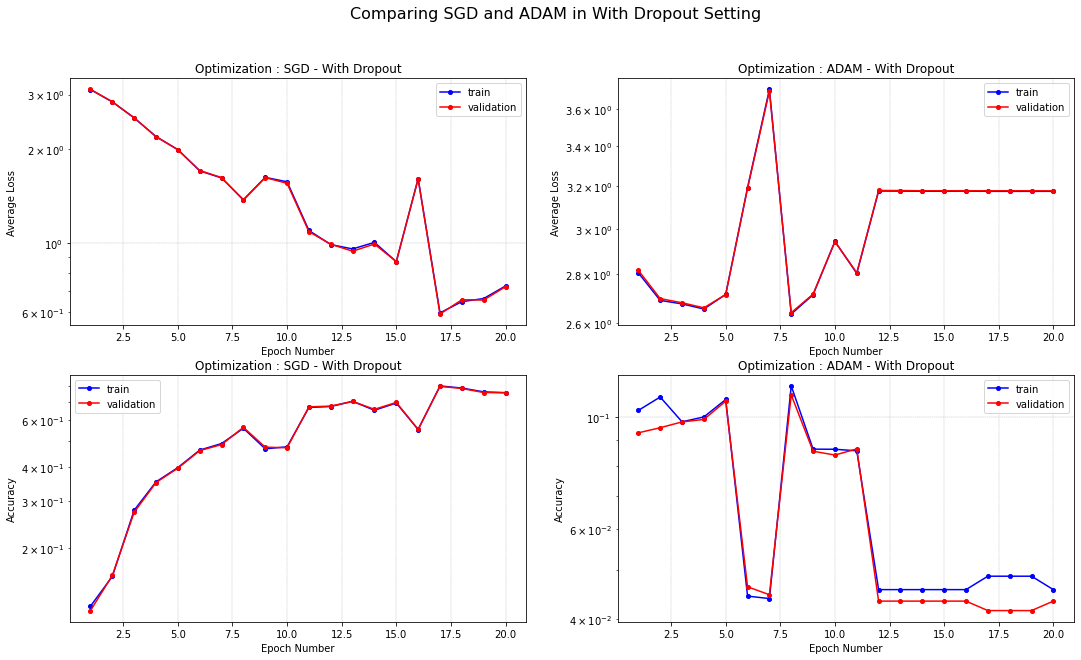

In [13]:
# Plotting the loss and accuracy curves
plt.figure(figsize=(18, 10))

plt.subplot(2, 2, 1)
plt.plot(range(1,21), optimizer_WithDropout_SGD.train_loss, label = 'train', color = 'b', marker = 'o', ms = 4)
plt.plot(range(1,21), optimizer_WithDropout_SGD.validation_loss, label = 'validation', color = 'r',  marker = 'o', ms = 4)
plt.xlabel('Epoch Number')
plt.ylabel('Average Loss')
plt.title('Optimization : SGD - With Dropout')
plt.grid(linestyle = '--', linewidth = 0.4)
plt.yscale('log')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(range(1,21), optimizer_WithDropout_ADAM.train_loss, label = 'train', color = 'b', marker = 'o', ms = 4)
plt.plot(range(1,21), optimizer_WithDropout_ADAM.validation_loss, label = 'validation', color = 'r',  marker = 'o', ms = 4)
plt.xlabel('Epoch Number')
plt.ylabel('Average Loss')
plt.title('Optimization : ADAM - With Dropout')
plt.grid(linestyle = '--', linewidth = 0.4)
plt.yscale('log')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(range(1,21), optimizer_WithDropout_SGD.train_accuracy, label = 'train', color = 'b', marker = 'o', ms = 4)
plt.plot(range(1,21), optimizer_WithDropout_SGD.validation_accuracy, label = 'validation', color = 'r',  marker = 'o', ms = 4)
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.title('Optimization : SGD - With Dropout')
plt.grid(linestyle = '--', linewidth = 0.4)
plt.yscale('log')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(range(1,21), optimizer_WithDropout_ADAM.train_accuracy, label = 'train', color = 'b', marker = 'o', ms = 4)
plt.plot(range(1,21), optimizer_WithDropout_ADAM.validation_accuracy, label = 'validation', color = 'r',  marker = 'o', ms = 4)
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.title('Optimization : ADAM - With Dropout')
plt.grid(linestyle = '--', linewidth = 0.4)
plt.yscale('log')
plt.legend()

plt.suptitle("Comparing SGD and ADAM in With Dropout Setting", size = 16)
plt.show()

<div dir="rtl"> <font size="4" face="vazirmatn">    
چون شبکه خودش ساده است و خیلی عمیق نیست استفاده از 
dropout 
آموزش شبکه را در هر دو روش 
SGD
و
ADAM
مختل می‌کند. در نتیجه همان شبکه‌های قسمت قبل بهتر هستند. اگر شبکه‌ها را پیچیده و عمیق‌تر کنیم احتمالا استفاده از 
dropout 
منجر به نتایج بهتری خواهد شد.
</font> </div> 

## Part d

In [16]:
model_names = ['SGD without Dropout','ADAM without Dropout','SGD with Dropout','ADAM with Dropout']
optimizers = [optimizer_NoDropout_SGD,optimizer_NoDropout_ADAM,optimizer_WithDropout_SGD,optimizer_WithDropout_ADAM]

best_accuracy = 0
for i in range(4):
  print(f"The model optimized by {model_names[i]} have:")
  correct, loss = optimizers[i].test_loop('test')
  print('-------------------------------------------------\n')
  if (correct > best_accuracy):
    best_model_index = i
    best_accuracy = correct

best_model = optimizers[best_model_index].model_builder.model
print('the best model is the model optimized by ' + model_names[best_model_index])

The model optimized by SGD without Dropout have:
test Accuracy: 80.3%, test Avg loss: 0.884575
-------------------------------------------------

The model optimized by ADAM without Dropout have:
test Accuracy: 71.1%, test Avg loss: 1.724950
-------------------------------------------------

The model optimized by SGD with Dropout have:
test Accuracy: 62.0%, test Avg loss: 1.278441
-------------------------------------------------

The model optimized by ADAM with Dropout have:
test Accuracy: 2.9%, test Avg loss: 3.200046
-------------------------------------------------

the best model is the model optimized by SGD without Dropout


## * Part e

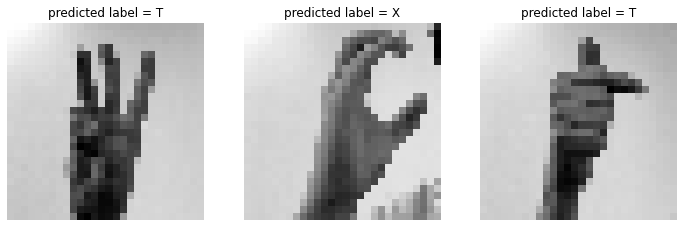

In [25]:
from torchvision.io import read_image
import torchvision.transforms as Transform

images = [read_image(dir + 'img1.png'), read_image(dir + 'img2.png'), read_image(dir + 'img3.png'),]

grayscale_transform = Transform.Grayscale()
resize_transform = Transform.Resize(size = (28,28))

plt.figure(figsize=(12, 12))
for i in range(3):
    images[i] = images[i][:3]
    images[i] = grayscale_transform(images[i]).float()
    images[i] = resize_transform(images[i])
    plt.subplot(1, 3, i+1)
    plt.imshow(images[i].squeeze(), cmap="gray")
    plt.axis(False)
    pred = best_model(images[i].reshape(1, -1).to(device))
    plt.title('predicted label = ' + test_data.classes[pred.argmax().item()])
plt.show()